### Текстовое описание набора данных

Набор данных Индекса гендерного неравенства (ИГН) обеспечивает комплексную оценку гендерного неравенства в разных странах, отражая гендерные различия в сфере здравоохранения, образования и экономических возможностей. Разработанный Программой развития Организации Объединенных Наций (ПРООН), индекс GII измеряет гендерное неравенство путем анализа показателей здоровья, расширения прав и возможностей и участия на рынке труда.
Этот набор данных включает баллы ГИИ, а также баллы по компонентам для каждого индикатора по более чем 190 странам в 2021 году.

In [1]:
# Импортирование библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
%matplotlib inline
sns.set(style="ticks")

In [2]:
data_loaded = pd.read_csv("data/Gender_Inequality_Index.csv")

In [3]:
data = data_loaded

In [4]:
# Названия стобцов и их тип данных, у которых есть пропуски
cols_with_na = [(i, data[i].dtypes) for i in data.columns if data[i].isna().sum() > 0]
cols_with_na

[('Human_development', dtype('O')),
 ('GII', dtype('float64')),
 ('Rank', dtype('float64')),
 ('Maternal_mortality', dtype('float64')),
 ('Seats_parliament', dtype('float64')),
 ('F_secondary_educ', dtype('float64')),
 ('M_secondary_educ', dtype('float64')),
 ('F_Labour_force', dtype('float64')),
 ('M_Labour_force', dtype('float64'))]

In [5]:
# есть ли отрицательные значения?
[i for i in data.select_dtypes(include=['int', 'float64']).columns if (data[i] < 0).any()]

[]

In [6]:
# Вывод процент пропусков
[(c, round(data[c].isnull().mean() * 100, 4)) for c in data.columns if data[c].isna().sum() > 0]

[('Human_development', 2.0513),
 ('GII', 12.8205),
 ('Rank', 12.8205),
 ('Maternal_mortality', 5.641),
 ('Seats_parliament', 1.0256),
 ('F_secondary_educ', 9.2308),
 ('M_secondary_educ', 9.2308),
 ('F_Labour_force', 7.6923),
 ('M_Labour_force', 7.6923)]

In [7]:
data.shape

(195, 11)

In [8]:
data.head()

,Country,Human_development,GII,Rank,Maternal_mortality,Adolescent_birth_rate,Seats_parliament,F_secondary_educ,M_secondary_educ,F_Labour_force,M_Labour_force
0,Switzerland,Very high,0.018,3.0,5.0,2.2,39.8,96.9,97.5,61.7,72.7
1,Norway,Very high,0.016,2.0,2.0,2.3,45.0,99.1,99.3,60.3,72.0
2,Iceland,Very high,0.043,8.0,4.0,5.4,47.6,99.8,99.7,61.7,70.5
3,Hong Kong,Very high,NaN,NaN,NaN,1.6,NaN,77.1,83.4,53.5,65.8
4,Australia,Very high,0.073,19.0,6.0,8.1,37.9,94.6,94.4,61.1,70.5


In [9]:
data.describe()

,GII,Rank,Maternal_mortality,Adolescent_birth_rate,Seats_parliament,F_secondary_educ,M_secondary_educ,F_Labour_force,M_Labour_force
count,170.000000,170.000000,184.000000,195.000000,193.000000,177.000000,177.000000,180.000000,180.000000
mean,0.344376,85.376471,160.027174,44.597949,24.701554,62.706780,67.068362,50.224444,69.863333
std,0.197105,49.210206,233.028867,38.422479,12.404319,29.528487,26.450033,15.905491,9.012734
min,0.013000,1.000000,2.000000,1.600000,0.000000,6.400000,13.000000,6.000000,43.900000
25%,0.177500,43.250000,12.750000,10.750000,16.500000,37.700000,44.800000,42.400000,65.050000
50%,0.363000,85.500000,53.000000,36.200000,23.600000,69.900000,71.200000,52.150000,69.350000
75%,0.505750,127.750000,188.250000,64.200000,33.600000,90.200000,92.500000,60.475000,75.525000
max,0.820000,170.000000,1150.000000,170.500000,55.700000,100.000000,100.000000,83.100000,95.500000


##### 1. Удалять пропущенные значения нецелесообразно ввиду небольшого размера датасета, поэтому проведем замену пропусков различными методами.

In [10]:
res = data.dropna(axis=1, how='all')
res.shape
# Размер не изменился, пустых строчек нет для удаления

(195, 11)

### Заполнение значения для одного признака

##### 2. Заполнение показателями центра распределения и константой

In [11]:
# Для внедрения значения используется класс SimpleImputer
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]
    imputer = SimpleImputer(strategy=strategy_param, 
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)
    return all_data.reshape((size,))

In [12]:
def research_impute_numeric_column(dataset, num_column, const_value=None):
    strategy_params = ['mean', 'median', 'most_frequent', 'constant']
    strategy_params_names = ['Среднее', 'Медиана', 'Мода']
    strategy_params_names.append('Константа = ' + str(const_value))
    
    original_temp_data = dataset[[num_column]].values
    size = original_temp_data.shape[0]
    original_data = original_temp_data.reshape((size,))
    
    new_df = pd.DataFrame({'Исходные данные':original_data})
       
    for i in range(len(strategy_params)):
        strategy = strategy_params[i]
        col_name = strategy_params_names[i]
        if (strategy!='constant') or (strategy == 'constant' and const_value!=None):
            if strategy == 'constant':
                temp_data = impute_column(dataset, num_column, strategy, fill_value_param=const_value)
            else:
                temp_data = impute_column(dataset, num_column, strategy)
            new_df[col_name] = temp_data
        
    sns.kdeplot(data=new_df)

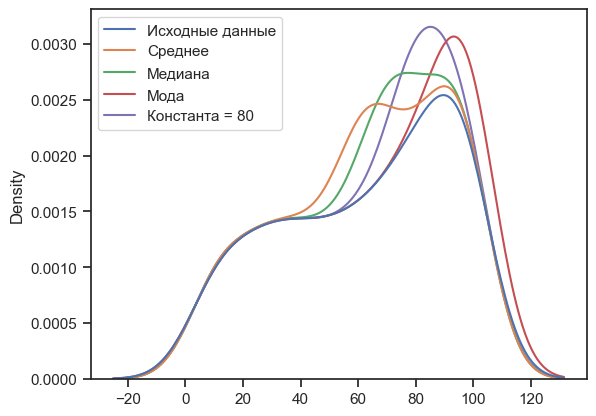

In [13]:
research_impute_numeric_column(data, 'F_secondary_educ', 80)

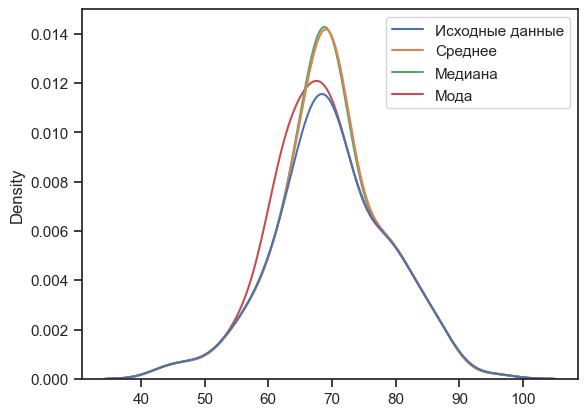

In [14]:
research_impute_numeric_column(data, 'M_Labour_force')

##### 3. Заполнение "хвостом распределения"

Параметр F_Labour_force, обозначающий уровень участия женщин в рабочей силе, больше похож на нормальной распределение. Определим для него верхнюю границу экстремальных значений в данных (extreme_value).

In [15]:
F_Labour_force_ev = data['F_Labour_force'].mean() + 3*data['F_Labour_force'].std()
F_Labour_force_ev

97.9409180646587

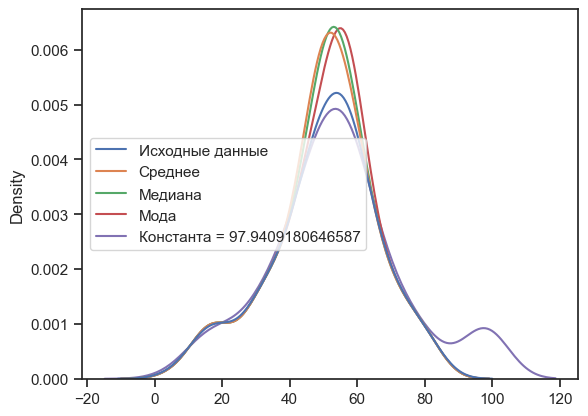

In [16]:
research_impute_numeric_column(data, 'F_Labour_force', F_Labour_force_ev)

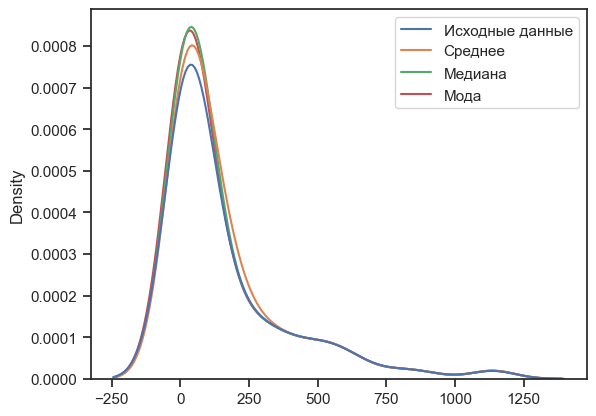

In [17]:
research_impute_numeric_column(data, 'Maternal_mortality')

На ассиметричное распределение больше похоже распределение параметра Maternal_mortality, обозначающий материнскую смертность.

IQR=175.5, extreme_value=714.75


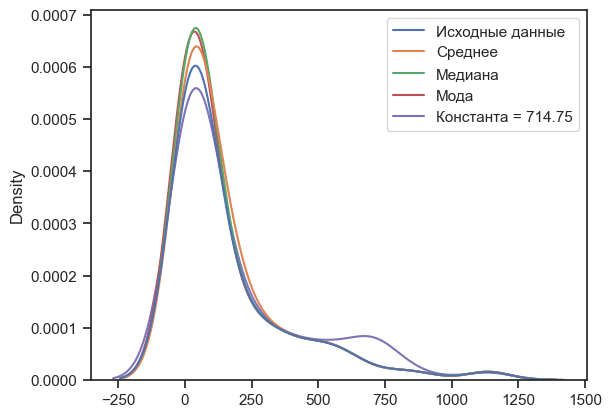

In [18]:
IQR = data['Maternal_mortality'].quantile(0.75) - data['Maternal_mortality'].quantile(0.25)
Maternal_mortality_ev1 = data['Maternal_mortality'].quantile(0.75) + 3*IQR
print(f'IQR={IQR}, extreme_value={Maternal_mortality_ev1}')
research_impute_numeric_column(data, 'Maternal_mortality', Maternal_mortality_ev1)

IQR=175.5, extreme_value=451.5


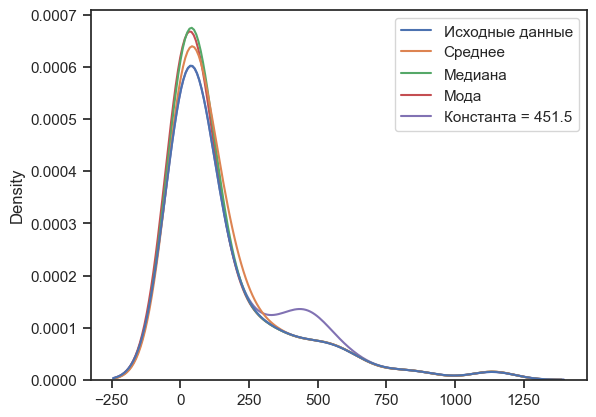

In [19]:
Maternal_mortality_ev2 = data['Maternal_mortality'].quantile(0.75) + 1.5*IQR
print(f'IQR={IQR}, extreme_value={Maternal_mortality_ev2}')
research_impute_numeric_column(data, 'Maternal_mortality', Maternal_mortality_ev2)

##### 3. Заполнение наиболее распространенным значением категории

Единственный категориальный признак с пропусками в данном датасете - это Human_development, обозначающий категорию человеческого развития в стране: Низкий-Очень высокий.

In [20]:
def plot_hist_diff(old_ds, new_ds, col):
    """
    Разница между распределениями до и после устранения пропусков
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.title.set_text('Поле - ' + str(col))
    old_ds[col].hist(bins=50, ax=ax, density=True, color='green')
    new_ds[col].hist(bins=50, ax=ax, color='blue', density=True, alpha=0.5)
    plt.show()

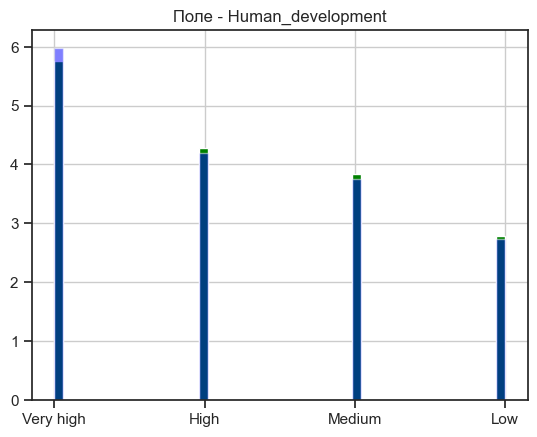

In [26]:
data_cat_new = data[['Human_development']].copy()
Human_development_cat_new_temp = impute_column(data_cat_new, 'Human_development', 'most_frequent')
data_cat_new['Human_development'] = Human_development_cat_new_temp
plot_hist_diff(data, data_cat_new, 'Human_development')

##### 4. Введение отдельного значения категории для пропущенных значений

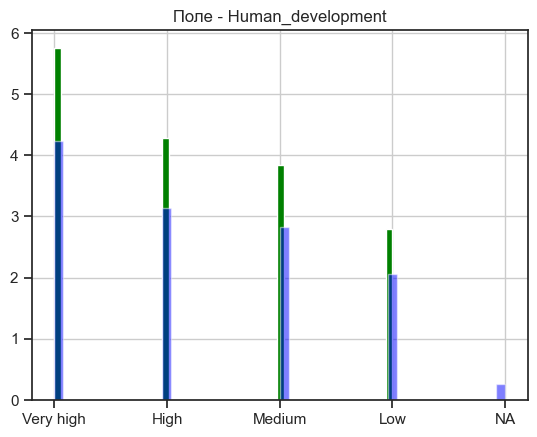

In [27]:
data_cat_na = data[['Human_development']].copy()
Human_development_cat_na = impute_column(data_cat_na, 'Human_development', 'constant', fill_value_param='NA')
data_cat_na['Human_development'] = Human_development_cat_na
plot_hist_diff(data, data_cat_na, 'Human_development')